In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
os.chdir(r'/content/drive/MyDrive/3semester/8160/hw8/')
from models import MyLSTM, MyGRU, MyRNN

In [5]:
class TrafficForecast(Dataset):
    def __init__(self,pkl_path, window, horizon):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.inputs = []
        self.targets = []


        df = pd.read_pickle(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)
        #split it into training and test 80 20
        self.seg_ids = self.df['segmentID'].unique()
        self.setup_forecast()

    def setup_forecast(self):
        for segid in self.seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time',ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill") # 1 nan nan nan 2, fulfill 2
            TI_series = df_seg_id['TrafficIndex_GP'].values
            h_series = df_seg_id['hour'].values
            #split it into training and test 80 20
            for t in range(0,len(TI_series)-(self.window+self.horizon)):
                x = TI_series[t:t+self.window]
                y = TI_series[t+self.window:(t+self.window+self.horizon)]
                h = h_series[t:t+self.window]
                x_cat = np.dstack([x, h])
                self.inputs.append(x_cat)
                self.targets.append(y)

    def __len__(self):
        return len(self.inputs)


    def __getitem__(self,idx):
        X = torch.tensor(self.inputs[idx],dtype=torch.float32).reshape(self.window, 2)
        y=torch.tensor(self.targets[idx],dtype=torch.float32)

        return {'inputs':X,'outputs':y}

In [71]:
def evaluation(model_arch,dataloader_test, bs):
    rmse = []
    maes = []
    ts = ToTensor()
    for i_test,sample_test in enumerate(dataloader_test):
        # ts(bs,window, horizon, sample_batched)
        sample_test = ts(bs,window,horizon,sample_test)
        preds = model_arch(sample_test['inputs'])
        preds = preds.reshape(bs,horizon,-1)
        targets = sample_test['outputs']
        error = ((preds-targets)**2).sum(1).mean().detach().numpy()
        mae = (preds-targets).abs().sum(1).mean().detach().numpy()
        rmse.append(math.sqrt(error))
        maes.append(mae)
    return {'rmse':np.mean(rmse),'mae':np.mean(maes)}

In [23]:
tps_df = pd.read_pickle('tps_df.pkl')
tps_df.fillna(0, inplace=True)
tps_df.head(10)

,time,segmentID,AVG_Spd_GP,AVG_Spd_HOV,AVG_Vol_GP,AVG_Vol_HOV,TrafficIndex_GP,TrafficIndex_HOV
0,2020-01-01 00:00:00.000,11,65.0,65.0,3.43,0.51,1.000,1.0
1,2020-01-01 00:00:00.000,12,65.0,65.0,4.73,1.90,1.000,1.0
2,2020-01-01 00:00:00.000,13,65.0,65.0,5.48,2.83,1.000,1.0
3,2020-01-01 00:00:00.000,14,65.0,65.0,5.26,2.84,1.000,1.0
4,2020-01-01 00:00:00.000,15,65.0,65.0,6.95,2.40,1.000,1.0
5,2020-01-01 00:00:00.000,16,65.0,65.0,6.26,2.24,1.000,1.0
6,2020-01-01 00:00:00.000,17,65.0,0.0,6.37,0.00,1.000,0.0
7,2020-01-01 00:00:00.000,18,64.8,0.0,8.64,0.00,0.997,0.0
8,2020-01-01 00:00:00.000,19,65.0,0.0,6.50,0.00,1.000,0.0
9,2020-01-01 00:00:00.000,20,65.0,65.0,5.70,0.53,1.000,1.0


In [24]:
reshaped_tps_df = pd.DataFrame()
reshaped_tps_df['TIME'] = tps_df.time.unique()
for seg in tps_df.segmentID.unique():
    column = tps_df[tps_df['segmentID'] == seg][['time','TrafficIndex_GP']].drop_duplicates(subset=['time'])
    column.columns = ['TIME', str(seg)]
    reshaped_tps_df = reshaped_tps_df.join(column.set_index('TIME'), on='TIME')

reshaped_tps_df = reshaped_tps_df.set_index('TIME')
reshaped_tps_df

,11,12,13,14,15,16,17,18,19,20,...,94,95,96,97,99,100,102,103,104,106
TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00.000,1.0,1.0,1.000,1.0,1.0,1.000,1.0,0.997,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-01-01 00:15:00.000,1.0,1.0,0.993,1.0,1.0,1.000,1.0,0.984,1.000,0.997,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-01-01 00:30:00.000,1.0,1.0,1.000,1.0,1.0,0.993,1.0,0.956,0.997,0.995,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-01-01 00:45:00.000,1.0,1.0,1.000,1.0,1.0,0.978,1.0,0.941,0.994,0.988,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.982
2020-01-01 01:00:00.000,1.0,1.0,1.000,1.0,1.0,0.982,1.0,0.940,0.997,0.989,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 22:45:00.000,1.0,1.0,1.000,1.0,1.0,1.000,1.0,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-05-31 23:00:00.000,1.0,1.0,1.000,1.0,1.0,1.000,1.0,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-05-31 23:15:00.000,1.0,1.0,1.000,1.0,1.0,1.000,1.0,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000


In [60]:
reshaped_tps_df.to_pickle('reshaped_tps_df.pkl')

In [54]:
tps_df1 = pd.read_pickle('tps_1.pkl')
tps_df1.fillna(0, inplace=True)
tps_df1.head(10)

,index,time,segmentID,AVG_Spd_GP,AVG_Spd_HOV,AVG_Vol_GP,AVG_Vol_HOV,TrafficIndex_GP,TrafficIndex_HOV
0,1507518,2020-06-01 21:15:00.000,11,64.82,65.0,6.99,1.07,0.994,1.0
1,1507519,2020-06-01 21:15:00.000,12,65.00,65.0,4.98,0.63,1.000,1.0
2,1507520,2020-06-01 21:15:00.000,13,65.00,65.0,4.78,0.95,1.000,1.0
3,1507521,2020-06-01 21:15:00.000,14,65.00,65.0,4.55,1.19,1.000,1.0
4,1507522,2020-06-01 21:15:00.000,15,65.00,65.0,5.01,1.12,1.000,1.0
5,1507523,2020-06-01 21:15:00.000,16,60.73,65.0,3.09,0.18,0.597,1.0
6,1507524,2020-06-01 21:15:00.000,17,65.00,0.0,0.20,0.00,1.000,0.0
7,1507525,2020-06-01 21:15:00.000,18,64.26,0.0,4.36,0.00,0.993,0.0
8,1507526,2020-06-01 21:15:00.000,19,62.84,0.0,4.69,0.00,0.995,0.0
9,1507527,2020-06-01 21:15:00.000,20,65.00,65.0,4.45,0.13,1.000,1.0


In [55]:
reshaped_tps_df1 = pd.DataFrame()
reshaped_tps_df1['TIME'] = tps_df1.time.unique()
for seg in tps_df1.segmentID.unique():
    column = tps_df[tps_df1['segmentID'] == seg][['time','TrafficIndex_GP']].drop_duplicates(subset=['time'])
    column.columns = ['TIME', str(seg)]
    reshaped_tps_df1 = reshaped_tps_df1.join(column.set_index('TIME'), on='TIME')

reshaped_tps_df1 = reshaped_tps_df1.set_index('TIME')
reshaped_tps_df1.head(10)

,11,12,13,14,15,16,17,18,19,20,...,94,95,96,97,99,100,102,103,104,106
TIME,,,,,,,,,,,,,,,,,,,,,
2020-06-01 21:15:00.000,0.994,1.0,1.0,1.0,1.0,0.597,1.0,0.993,0.995,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-01 21:30:00.000,1.000,1.0,1.0,1.0,1.0,0.617,1.0,0.992,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-01 21:45:00.000,1.000,1.0,1.0,1.0,1.0,0.600,1.0,0.997,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-01 22:00:00.000,1.000,1.0,1.0,1.0,1.0,0.522,1.0,0.980,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-01 22:15:00.000,1.000,1.0,1.0,1.0,1.0,0.601,1.0,0.998,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-01 22:30:00.000,1.000,1.0,1.0,1.0,1.0,0.577,1.0,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-01 22:45:00.000,1.000,1.0,1.0,1.0,1.0,0.559,1.0,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-01 23:00:00.000,1.000,1.0,1.0,1.0,1.0,0.987,1.0,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-06-01 23:15:00.000,1.000,1.0,1.0,1.0,1.0,1.000,1.0,1.000,1.000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [57]:
reshaped_tps_df1.to_pickle('reshaped_tps_df1.pkl')

In [61]:
tobj = TrafficForecast('tps_df.pkl',36,36)
tobj_test = TrafficForecast('tps_1.pkl',36,36)

In [41]:
bs = 1024
dataloader_train = DataLoader(tobj, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)
dataloader_test = DataLoader(tobj_test, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
for idx, data in enumerate(dataloader_train):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx == 3:
        break


torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

RNN

In [67]:
model2 = MyRNN(input_size=2, hidden_size=10, num_layers=2,output_size=36, bias=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [68]:
mean_loss = []
mean_test_loss = []
losses = []
test_losses = []
n_epochs = 3

# ts = ToTensor()
for it in tqdm(range(n_epochs)):

  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model2(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  # for i_test, sample_test in enumerate(dataloader_test):
  #     outputs = model2(sample_test['inputs'].to(device))
  #     test_loss = criterion(outputs, sample_test['outputs'].to(device))
  #     test_losses.append(test_loss.item())

  mean_loss.append(np.mean(losses))
  # mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 10 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}, Testing Loss: {np.mean(test_losses):.4f}')

 33%|███▎      | 1/3 [01:09<02:18, 69.08s/it]

Epoch 1/3, Training Loss: 0.1630, Testing Loss: nan


 67%|██████▋   | 2/3 [02:23<01:12, 72.29s/it]

Epoch 2/3, Training Loss: 0.0869, Testing Loss: nan


100%|██████████| 3/3 [03:33<00:00, 71.06s/it]

Epoch 3/3, Training Loss: 0.0615, Testing Loss: nan


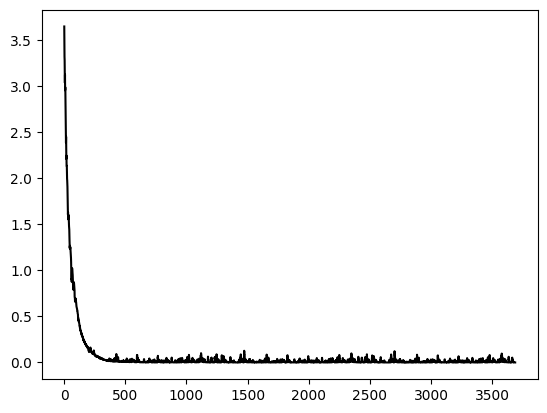

In [69]:
plt.plot(losses,'k',label='training')
# plt.plot(test_losses,'r',label='testing')
# plt.legend()

In [13]:
torch.save(model2.state_dict(), 'rnnmodel.pt')

In [74]:
model_arch = MyRNN(input_size=2,hidden_size=10,num_layers=2,output_size=36)
model_arch.load_state_dict(torch.load('rnnmodel.pt'))
model2.eval()

MyRNN(
  (rnn_cell_list): ModuleList(
    (0): MyRNNCell(
      (x2h): Linear(in_features=2, out_features=10, bias=True)
      (h2h): Linear(in_features=10, out_features=10, bias=True)
      (nonlinearity): ReLU()
    )
    (1-2): 2 x MyRNNCell(
      (x2h): Linear(in_features=10, out_features=10, bias=True)
      (h2h): Linear(in_features=10, out_features=10, bias=True)
      (nonlinearity): ReLU()
    )
  )
  (fc): Linear(in_features=10, out_features=36, bias=True)
)

In [76]:
with torch.no_grad():
    for i_test, sample_test in enumerate(dataloader_test):
        outputs = model_arch(sample_test['inputs'].to(device))

In [75]:
results = evaluation(model_arch,dataloader_test,bs)
print (results)

{'rmse': nan, 'mae': nan}


In [70]:
output_1 = pd.DataFrame(prediction_result)
output_1.index = pd.date_range(start='2020-06-01 16:15:00', end='2020-06-01 19:00:00', freq='15min').astype(int) / 10**9


LSTM

In [15]:
model = MyLSTM(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  # for i_test, sample_test in enumerate(dataloader_test):
#     outputs = model2(sample_test['inputs'].to(device))
#     test_loss = criterion(outputs, sample_test['outputs'].to(device))
#     test_losses.append(test_loss.item())

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 1/3 [03:45<07:31, 225.71s/it]

Epoch 1/3, Training Loss: 0.0493


 67%|██████▋   | 2/3 [07:21<03:39, 219.94s/it]

Epoch 2/3, Training Loss: 0.0303


100%|██████████| 3/3 [10:50<00:00, 216.76s/it]

Epoch 3/3, Training Loss: 0.0239


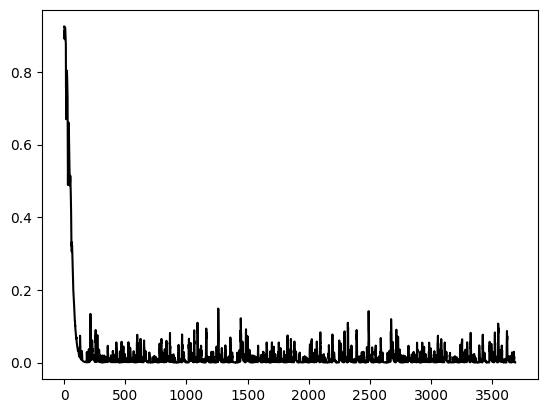

In [17]:
plt.plot(losses,'k',label='training')

In [18]:
torch.save(model.state_dict(), 'MyLSTM.pt')

GRU

In [19]:
model1 = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model1.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [20]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model1(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  # for i_test, sample_test in enumerate(dataloader_test):
#     outputs = model2(sample_test['inputs'].to(device))
#     test_loss = criterion(outputs, sample_test['outputs'].to(device))
#     test_losses.append(test_loss.item())

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

 33%|███▎      | 1/3 [02:32<05:04, 152.01s/it]

Epoch 1/3, Training Loss: 0.0833


 67%|██████▋   | 2/3 [05:03<02:31, 151.74s/it]

Epoch 2/3, Training Loss: 0.0472


100%|██████████| 3/3 [07:32<00:00, 150.73s/it]

Epoch 3/3, Training Loss: 0.0352


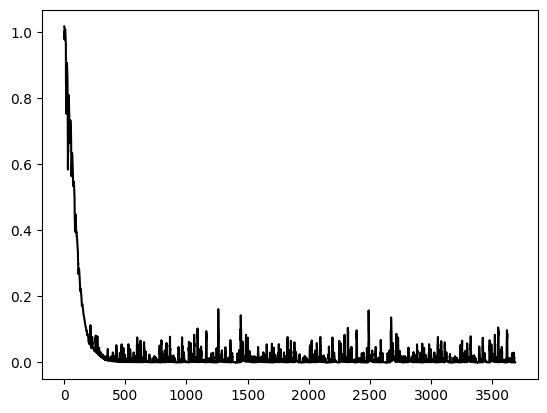

In [21]:
plt.plot(losses,'k',label='training')

In [22]:
torch.save(model1.state_dict(), 'grumodel.pt')